In [15]:
from srcmap import *
from mask import *
from utils_plotting import *
from power_spec import *
from IPython.display import clear_output
import seaborn as sns
sns.set()

In [5]:
inst = 1
make_srcmap_class = make_srcmap(inst, Re2 = 2)

srcmap = make_srcmap_class.run_srcmap(ptsrc=True)
clear_output()

modmap = make_srcmap_class.run_srcmap()
clear_output()

mzmask, _ = MZ14_mask(inst, make_srcmap_class.xls, 
                   make_srcmap_class.yls, make_srcmap_class.ms_inband)
clear_output()

mzmask_mkk = mask_Mkk(mzmask)
mzmask_mkk.get_Mkk_sim(verbose=False)
clear_output()

psfmap = make_srcmap_class.psf_map

In [35]:
l,Cls0,Cls0err = get_power_spec(srcmap, mask=mzmask)
l,Clm0,Clm0err = get_power_spec(modmap, mask=mzmask)
Cls, Clserr = mzmask_mkk.Mkk_correction(Cls0, Clerr=Cls0err)
Clm, Clmerr = mzmask_mkk.Mkk_correction(Clm0, Clerr=Clm0err)
bl = get_bl(psfmap, l)

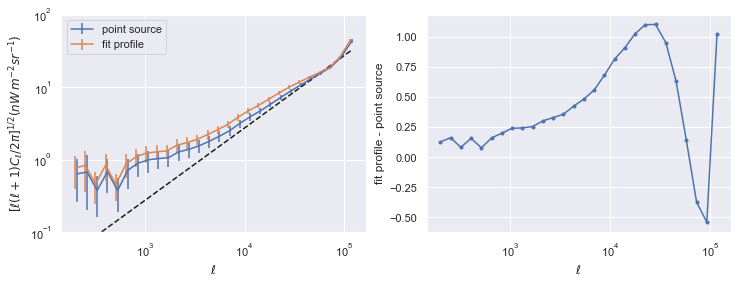

In [24]:
Dls = np.sqrt(Cls*l*(l+1)/2/np.pi/bl)
Dlm = np.sqrt(Clm*l*(l+1)/2/np.pi/bl)
Dlserr = np.sqrt(Clserr*l*(l+1)/2/np.pi/bl)
Dlmerr = np.sqrt(Clserr*l*(l+1)/2/np.pi/bl)
refline = np.sqrt(l*(l+1))
refline /= refline[-4]
refline *= np.sqrt(Cls*l*(l+1)/2/np.pi/bl)[-4]

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].errorbar(l*1.02, Dls, Dlserr, label='point source')
ax[0].errorbar(l*0.98, Dlm, Dlmerr, label='fit profile')
ax[0].plot(l, refline, 'k--')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylim([1e-1,1e2])
ax[0].set_xlabel(r'$\ell$')
ax[0].set_ylabel(r'$[ \ell(\ell+1)C_\ell/2\pi ]^{1/2}( nW\,m^{-2} sr^{-1})$')
ax[0].legend()

ax[1].semilogx(l, Dlm - Dls, '.-')
ax[1].set_xlabel(r'$\ell$')
ax[1].set_ylabel('fit profile - point source')
plt.savefig('plots/TM%d/excess_power_spec.png'%inst, dpi = 150, bbox_inches='tight')

Text(0, 0.5, '$(C_\\ell^{+IHL}/C_\\ell)-1$')

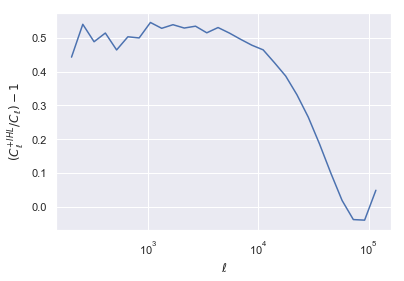

In [43]:
plt.semilogx(l, (Clm/Cls)-1)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$(C_\ell^{+IHL}/C_\ell)-1$')

***

In [18]:
from srcmap import *
from mask import *
from power_spec import *
from micecat import *

# df = get_micecat_df(0)
dfc = df.loc[df['flag_central']==0]
dfs = df.copy()
dfs['Fnu_I'] = 3631 * 10**(-df['I'] / 2.5)
dfs['Fnu_H'] = 3631 * 10**(-df['H'] / 2.5)
dfs1 = dfs.groupby('unique_halo_id')[['Fnu_I','Fnu_H']].sum()
dfc = dfc.join(dfs1, on='unique_halo_id', how='inner')
dfc['I'] = -2.5 * np.log10(dfc['Fnu_I']/3631)
dfc['H'] = -2.5 * np.log10(dfc['Fnu_H']/3631)

In [20]:
# data = {}
# mag_th = 20
# data['mag_th'] = mag_th
# for i,(name,dfi) in enumerate(zip(['full','cen'],[df,dfc])):
#     xs, ys, ms = np.array(dfi['x']), np.array(dfi['y']), np.array(dfi['I'])
    
#     print('making mask for %s'%name)
#     mask,num = MZ14_mask(1,xs,ys,ms,verbose=False)
    
#     print('get mkk for %s'%name)
#     mask_mkk = mask_Mkk(mask)
#     mask_mkk.get_Mkk_sim(Nsims=50,verbose=True)
#     spb = np.where(dfi['I']<=mag_th)[0]
#     spf = np.where(dfi['I']>mag_th)[0]

#     data[name] = {'mask':mask, 'mask_mkk':mask_mkk}

#     for inst in [1,2]:
#         ms_inband = np.array(dfi['I']) if inst==1 else np.array(dfi['H'])
        
#         print('making srcmap for %s TM %d'%(name,inst))
#         make_srcmap_class = make_srcmap(inst)

#         make_srcmap_class.ms = ms[spb]
#         make_srcmap_class.ms_inband = ms_inband[spb]
#         make_srcmap_class.xls = xs[spb]
#         make_srcmap_class.yls = ys[spb]
#         srcmapb = make_srcmap_class.run_srcmap(ptsrc=True, verbose=True)

#         make_srcmap_class.ms = ms[spf]
#         make_srcmap_class.ms_inband = ms[spf]
#         make_srcmap_class.xls = xs[spf]
#         make_srcmap_class.yls = ys[spf]
#         srcmapf = make_srcmap_class.run_srcmap_nopsf()
#         srcmap = srcmapb + srcmapf

#         data[name][inst] = {}
#         data[name][inst]['srcmap'] = srcmap

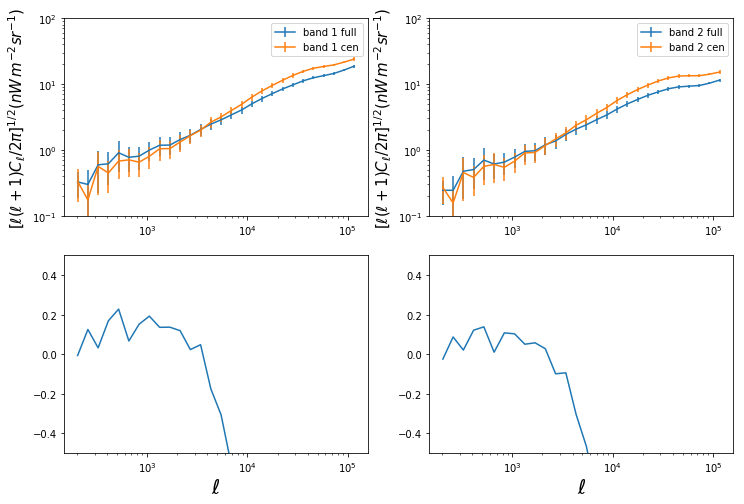

In [42]:
fig, ax = plt.subplots(2,2, figsize=(12,8))


for i,inst in enumerate([1,2]):
    for name in ['full','cen']:
        l,Cl0,Cl0err = get_power_spec(data[name][inst]['srcmap'], mask=data[name]['mask'])
        Cl, Clerr = mask_mkk.Mkk_correction(Cl0, Clerr=Cl0err)
        Dl0 = np.sqrt(Cl0*l*(l+1)/2/np.pi)
        Dl0err = np.sqrt(Cl0err*l*(l+1)/2/np.pi)
        Dl = np.sqrt(Cl*l*(l+1)/2/np.pi)
        Dlerr = np.sqrt(Clerr*l*(l+1)/2/np.pi)
        if name == 'full':
            Dlf = Dl
        else:
            Dlc = Dl
        
        ax[0][i].errorbar(l, Dl, Dlerr, label='band %d %s'%(inst, name))
        ax[0][i].set_xscale('log')
        ax[0][i].set_yscale('log')
        ax[0][i].set_ylim([1e-1,1e2])
        ax[0][i].set_ylabel(r'$[ \ell(\ell+1)C_\ell/2\pi ]^{1/2}( nW\,m^{-2} sr^{-1})$',fontsize=15)
        ax[0][i].legend()

    ax[1][i].semilogx(l, Dlf-Dlc)
    ax[1][i].set_ylim([-0.5,0.5])
    ax[1][i].set_xlabel(r'$\ell$',fontsize=20)